In [1]:
import pandas as pd
import numpy as np
import ast
import re
import os
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns
import streamlit as st
from scipy.stats import mstats
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import joblib

# Ignore warnings
warnings.filterwarnings("ignore")

# Function to clean input values
def clean_value(value):
    if pd.isna(value):
        return None
    elif isinstance(value, str):
        return value.strip()
    return value

# Function to safely convert string representations of dictionaries
def str_to_dict(value):
    if isinstance(value, dict):
        return value
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)
        except (ValueError, SyntaxError):
            return {}
    return {}

# Function to clean kilometers driven values
def clean_kms_driven(value):
    if isinstance(value, str):
        return int(re.sub(r'\D', '', value))
    return value

# Function to clean price values
def clean_price(value):
    if isinstance(value, str):
        value = value.replace('₹', '').replace(',', '').strip()
        if 'Crore' in value:
            value = value.replace('Crore', '').strip()
            return float(value) * 10000000
        elif 'Lakh' in value:
            value = value.replace('Lakh', '').strip()
            return float(value) * 100000
        return float(value)
    if value:
        return value
    return None

# Function to clean registration year values
def clean_registration_year(value):
    if isinstance(value, str):
        return re.sub(r'\b[A-Za-z]{3,9}\s+', '', value)
    return value

# Function to clean other attributes
def clean_attribute(value, suffix):
    return re.sub(fr'\s*{suffix}', '', value) if isinstance(value, str) else value

# 1a. Import and concatenate datasets
file_paths = [
    'bangalore_cars.xlsx',
    'chennai_cars.xlsx',
    'delhi_cars.xlsx',
    'hyderabad_cars.xlsx',
    'jaipur_cars.xlsx',
    'kolkata_cars.xlsx'
]
dfs = []
for file_path in file_paths:
    df = pd.read_excel(file_path)
    location = file_path.split('_')[0].capitalize()
    df['City'] = location
    dfs.append(df)
combined_df = pd.concat(dfs, ignore_index=True)

# 1b. Process each row in the combined DataFrame
processed_rows = []

for index, row in combined_df.iterrows():
    new_car_detail = str_to_dict(row['new_car_detail'])
    flat_entry = {
        'Fuel Type': new_car_detail.get('ft'),
        'Body Type': new_car_detail.get('bt'),
        'Kms Driven': clean_kms_driven(new_car_detail.get('km')),
        'Transmission': new_car_detail.get('transmission'),
        'Owner': clean_value(new_car_detail.get('ownerNo')),
        'Owner Details': new_car_detail.get('owner'),
        'OEM': new_car_detail.get('oem'),
        'Model': new_car_detail.get('model'),
        'Model Year': clean_value(new_car_detail.get('modelYear')),
        'Variant Name': new_car_detail.get('variantName'),
        'Price': clean_price(new_car_detail.get('price')),
        'City': clean_value(row['City']),
        'Car Link': row.get('car_links')
    }
    
    if 'new_car_overview' in row:
        new_car_overview = str_to_dict(row['new_car_overview'])
        for item in new_car_overview.get('top', []):
            key = item.get('key')
            value = item.get('value')
            if key == 'Registration Year':
                flat_entry['Registration Year'] = clean_registration_year(value)
            elif key == 'Insurance Validity':
                flat_entry['Insurance Validity'] = value
            elif key == 'Seats':
                flat_entry['Seats'] = clean_attribute(value, 'Seats')
            elif key == 'Engine Displacement':
                flat_entry['Engine Displacement'] = clean_attribute(value, 'cc')
                
    if 'new_car_feature' in row:
        new_car_feature = str_to_dict(row['new_car_feature'])
        for feature in new_car_feature.get('top', []):
            value = feature.get('value')
            if value:
                flat_entry.setdefault('Entertainment', []).append(value)
        for category in new_car_feature.get('data', []):
            heading = category.get('heading', '')
            items = category.get('list', [])
            for item in items:
                value = item.get('value', '')
                if value:
                    flat_entry.setdefault(heading, []).append(value)

    processed_rows.append(flat_entry)

    if 'new_car_specs' in row:
        new_car_specs = str_to_dict(row['new_car_specs'])
        for spec in new_car_specs.get('top', []):
            key = spec.get('key')
            value = spec.get('value')
            if key == 'Mileage':
                flat_entry['Mileage'] = clean_attribute(value, 'kmpl')
            elif key == 'Engine':
                flat_entry['Engine'] = clean_attribute(value, 'CC')
            elif key == 'Max Power':
                flat_entry['Max Power'] = clean_attribute(value, 'bhp')
            elif key == 'Torque':
                flat_entry['Torque'] = clean_attribute(value, 'Nm')
            elif key == 'Wheel Size':
                flat_entry['Wheel Size'] = clean_value(value)
            elif key == 'Seats':
                flat_entry['Seating Capacity'] = clean_value(value)

# 1c. Create a DataFrame from the processed rows
processed_df = pd.DataFrame(processed_rows)

# 1d. Handling Missing Values
categorical_cols = [
    'Fuel Type', 'Body Type', 'Transmission', 'Owner Details', 'OEM', 'Model', 
    'Variant Name', 'City', 'Insurance Validity', 'Seats', 
    'Comfort & Convenience', 'Interior', 'Exterior', 'Safety', 
    'Entertainment', 'Car Link'
]

# Fill categorical columns with the mode
for col in categorical_cols:
    if processed_df[col].isnull().any():
        mode_value = processed_df[col].mode()[0]
        # Ensure we are filling with a scalar
        if isinstance(mode_value, list):
            mode_value = mode_value[0]  # Take the first item if mode is a list
        processed_df[col] = processed_df[col].fillna(mode_value)

numerical_cols = [
    'Kms Driven', 'Price', 'Registration Year',
    'Engine Displacement', 'Mileage', 'Engine',
    'Max Power', 'Torque', 'Seating Capacity', 'Wheel Size', 'Owner'
]

# Fill numerical columns with the median
for col in numerical_cols:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')
    if processed_df[col].isnull().any():
        median_value = processed_df[col].median()
        # Ensure we are filling with a scalar
        if isinstance(median_value, list):
            median_value = median_value[0]  # Take the first item if median is a list
        processed_df[col] = processed_df[col].fillna(median_value)


# 1e. Standardizing Data Formats
float_columns = ['Mileage', 'Max Power', 'Torque']
for col in float_columns:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce').fillna(0.0)

int_columns = [
    'Price', 'Registration Year', 'Seats',
    'Engine Displacement', 'Engine', 'Seating Capacity', 'Wheel Size', 'Owner'
]
for col in int_columns:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce').fillna(0).astype(int)

# 1f. Feature Engineering
current_year = datetime.now().year
processed_df['Age of Car'] = current_year - processed_df['Registration Year']

# Set the limit for top N unique values
columns_to_drop = [
    'Variant Name', 
    'Car Link',
    'Owner Details',
    'Comfort & Convenience', 
    'Interior', 
    'Exterior', 
    'Entertainment & Communication',
    'Entertainment',
    'Safety'
]

# Step 2: Drop the specified categorical columns
df_dropped = processed_df.drop(columns=columns_to_drop, errors='ignore')

# Ensure that the 'Insurance Validity' column is cleaned and mapped to numeric values
def map_insurance_validity(value):
    if value == 'Third Party insurance':
        return 1
    elif value == 'Comprehensive':
        return 2
    elif value == 'Third Party':
        return 3
    elif value == 'Zero Dep':
        return 4
    elif value in ['1', '2', 'Not Available', '']:  # Includes empty strings
        return 0  # All these values will map to 0
    else:
        return -1  # for any unexpected values

# Apply mapping to the 'Insurance Validity' column
df_dropped['Insurance Validity'] = df_dropped['Insurance Validity'].apply(map_insurance_validity)

# Proceed with One-Hot Encoding and Label Encoding as before
# 1. Ensure all categorical columns exist, filling missing ones with 'Unknown'
columns_to_encode = ['Fuel Type', 'Body Type', 'Transmission', 'OEM', 'Model', 'City']
for col in columns_to_encode:
    if col not in df_dropped.columns:
        df_dropped[col] = 'Unknown'  # Fill missing columns with 'Unknown'

# 2. Apply one-hot encoding after ensuring all columns are present
df_encoded = pd.get_dummies(df_dropped, columns=columns_to_encode, drop_first=True)

# 3. Convert boolean columns to integers (0/1)
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

# Now, df_encoded should have no missing columns and be ready for further use.


# Now, you can directly use df_encoded
df_cleaned = df_encoded.copy()

# Remove outliers using the Z-score method across multiple columns
def remove_outliers_z_score(df, columns, threshold=3):
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=columns)
    z_scores = np.abs(stats.zscore(df_clean[columns]))
    return df_clean[(z_scores < threshold).all(axis=1)]

# Numerical columns for outlier removal
numerical_columns = ['Price', 'Mileage'] 

# Apply Z-score based outlier removal
df_cleaned = remove_outliers_z_score(df_cleaned, numerical_columns)

# Check the final data shape
print(f"Data shape after outlier removal: {df_cleaned.shape}")

# Save the processed DataFrame to a CSV file with versioning
output_file = 'df_cleaned_car_details.csv'
base_name, ext = os.path.splitext(output_file)
version = 1
while os.path.exists(output_file):
    output_file = f"{base_name}_v{version}{ext}"
    version += 1

df_cleaned.to_csv(output_file, index=False)
print(f"Data has been processed and saved as {output_file}.")

output_file = 'combined_car_details.csv'
base_name, ext = os.path.splitext(output_file)
version = 1
while os.path.exists(output_file):
    output_file = f"{base_name}_v{version}{ext}"
    version += 1
processed_df.to_csv(output_file, index=False)
print(f"Data has been processed and saved as {output_file}.")


Data shape after outlier removal: (8187, 381)
Data has been processed and saved as df_cleaned_car_details.csv.
Data has been processed and saved as combined_car_details.csv.


## Descriptive Statistics
Summary Statistics for numerical columns in the dataset:
         Kms Driven        Owner   Model Year         Price  \
count  8.187000e+03  8187.000000  8187.000000  8.187000e+03   
mean   5.962590e+04     1.364847  2016.426163  8.261984e+05   
std    7.466850e+04     0.645721     3.916302  7.715723e+05   
min    0.000000e+00     0.000000  1985.000000  2.016100e+04   
25%    3.100000e+04     1.000000  2014.000000  3.950000e+05   
50%    5.448100e+04     1.000000  2017.000000  6.000000e+05   
75%    8.000000e+04     2.000000  2019.000000  9.204995e+05   
max    5.500000e+06     5.000000  2023.000000  5.200000e+06   

       Registration Year  Insurance Validity        Seats  \
count        8187.000000         8187.000000  8187.000000   
mean         2016.538659            1.603151     5.205448   
std             3.793930            0.816370     0.659872   
min          2002.000000            0.000000     2.000000   
25%          2014.000000            1.000000

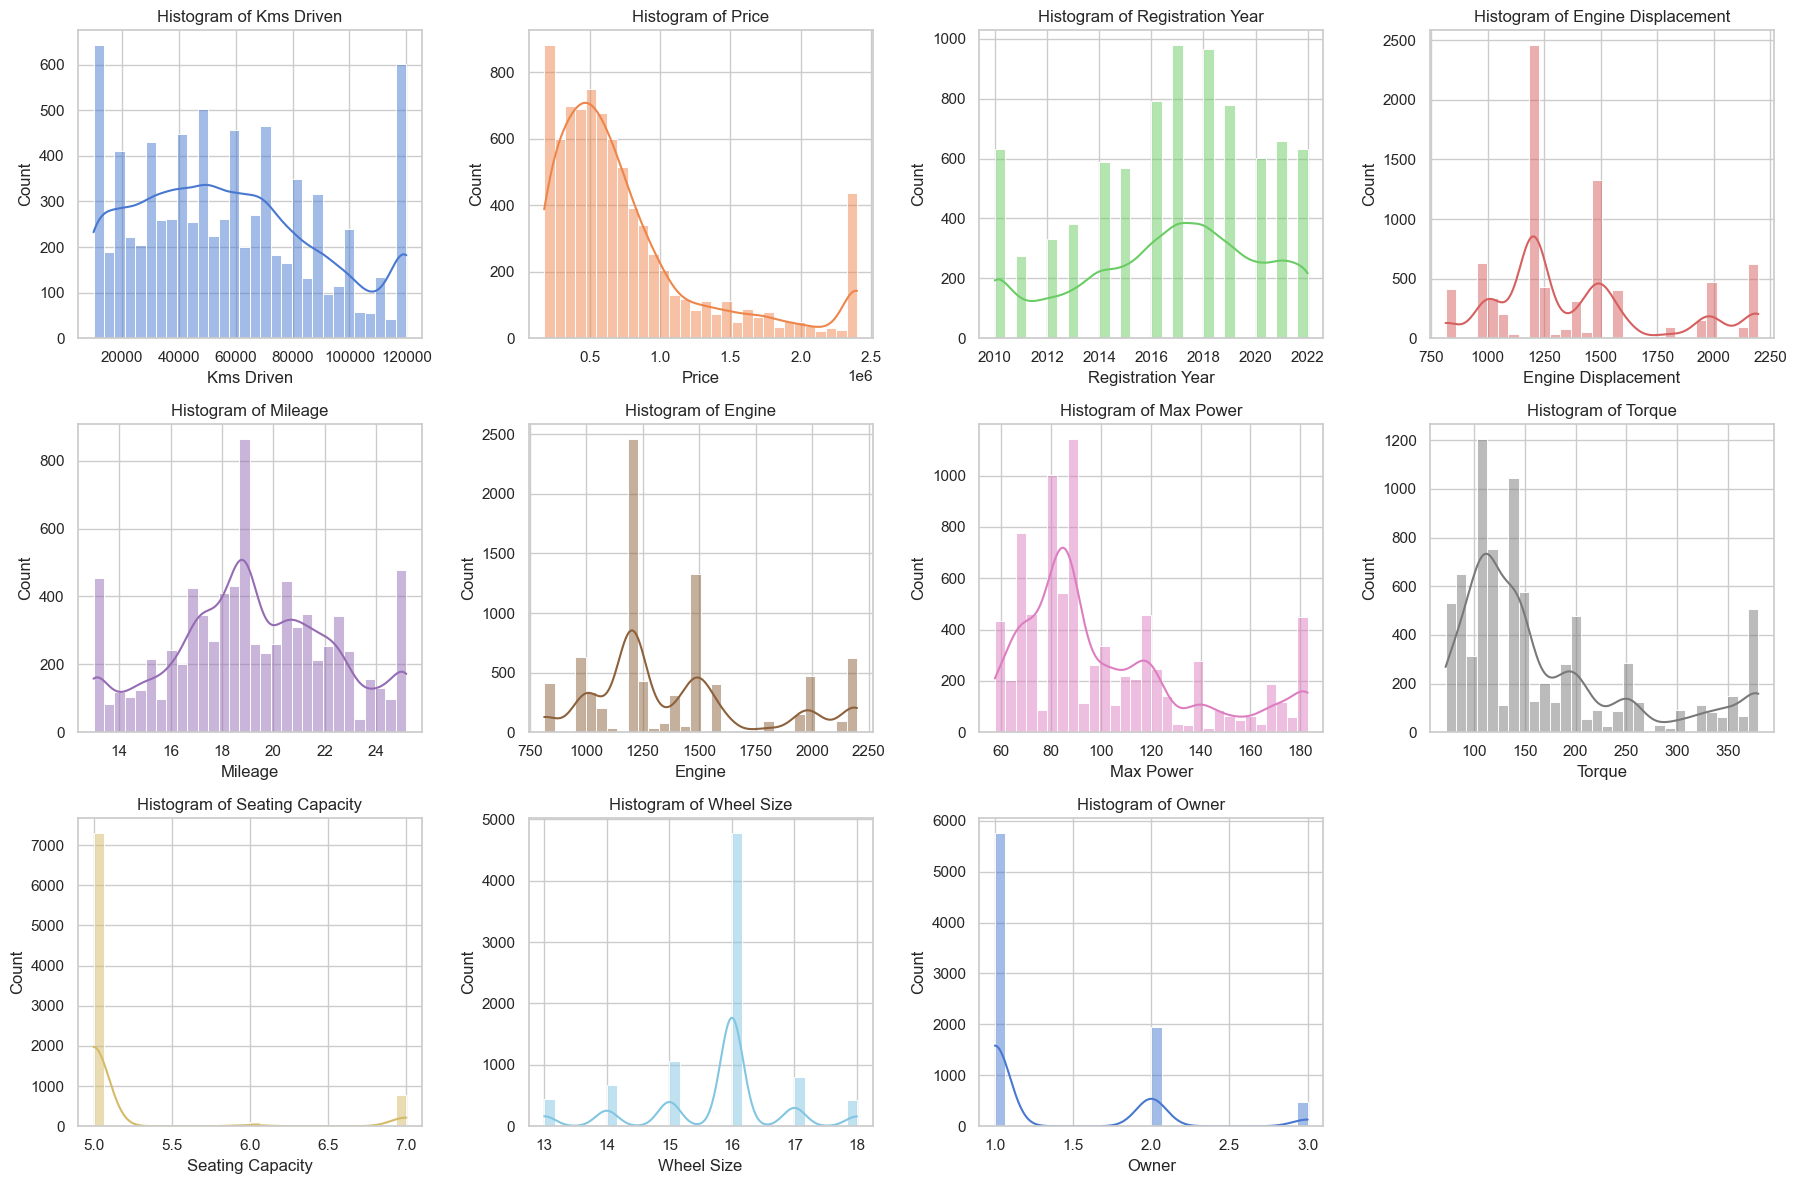

### Box Plots for Outlier Detection


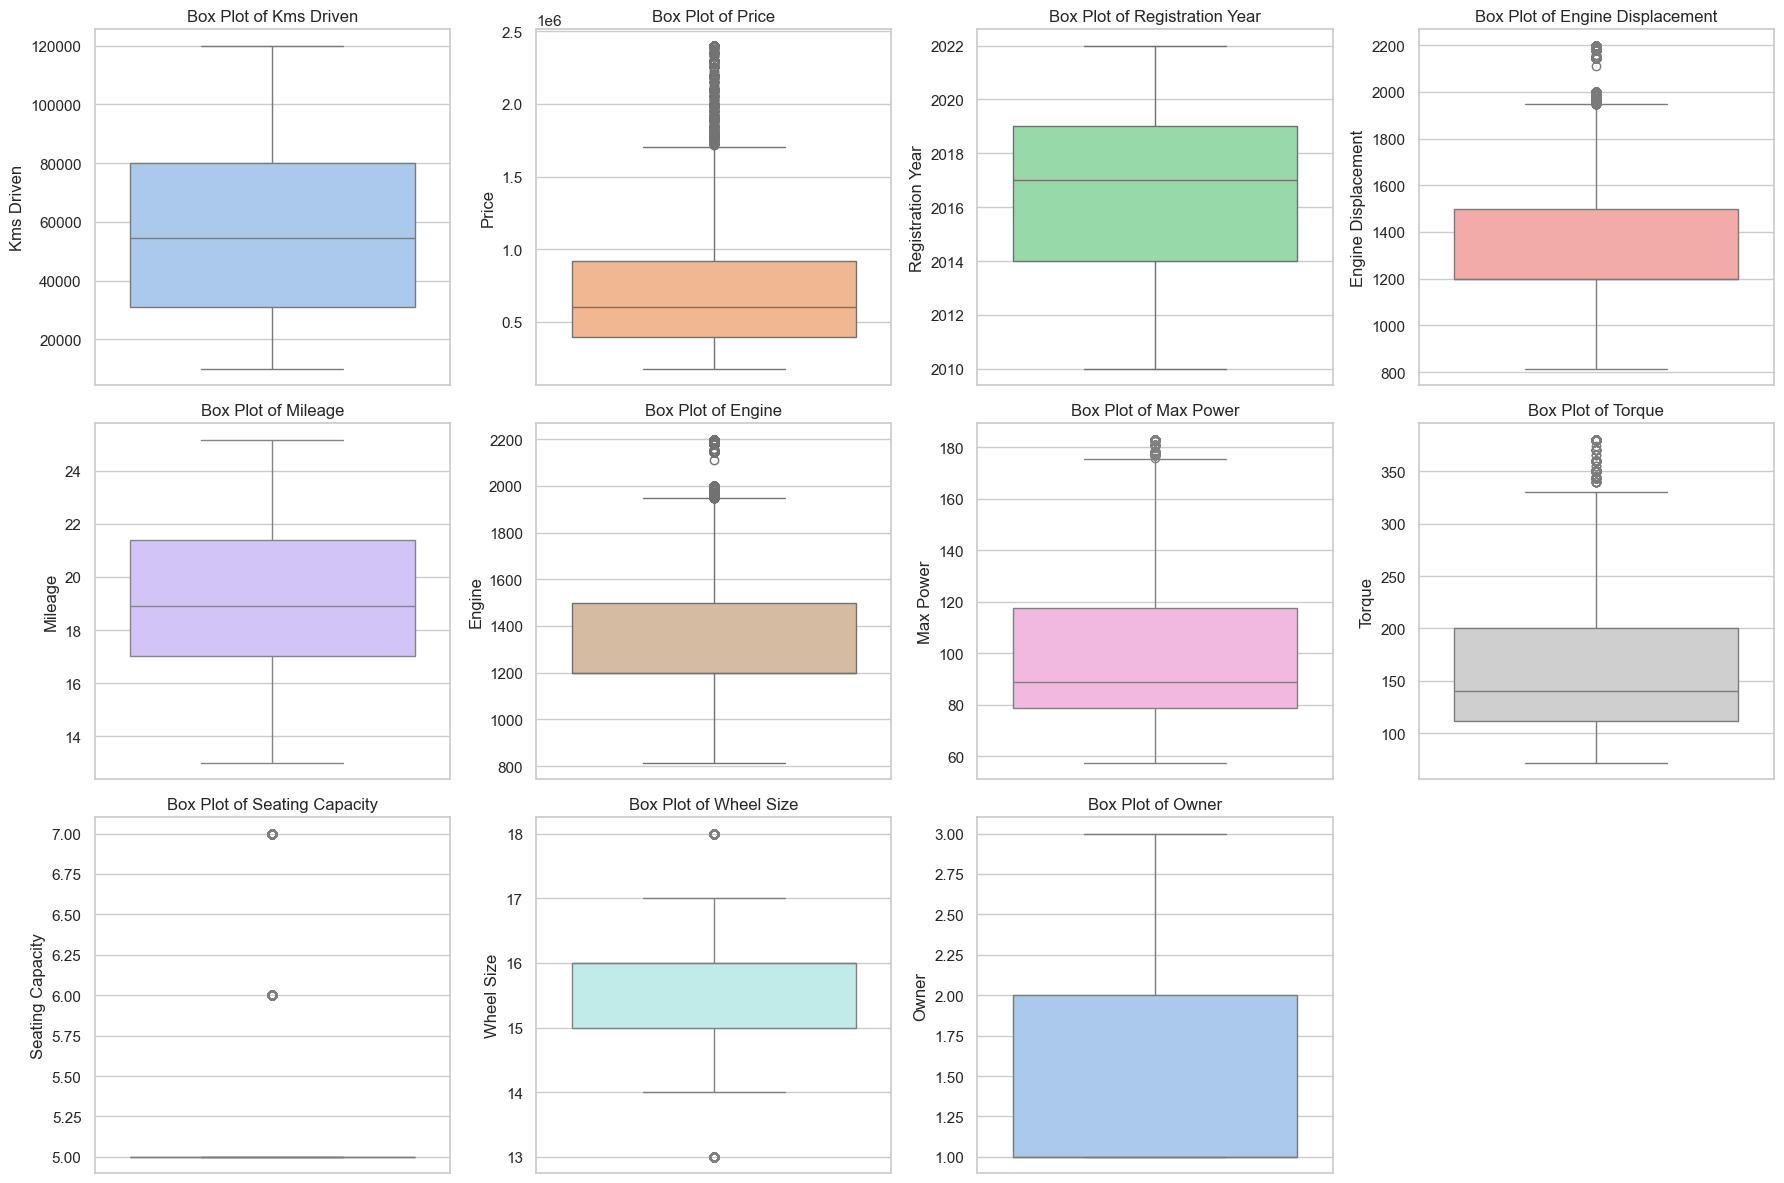

### Scatter Plots of Features vs Price


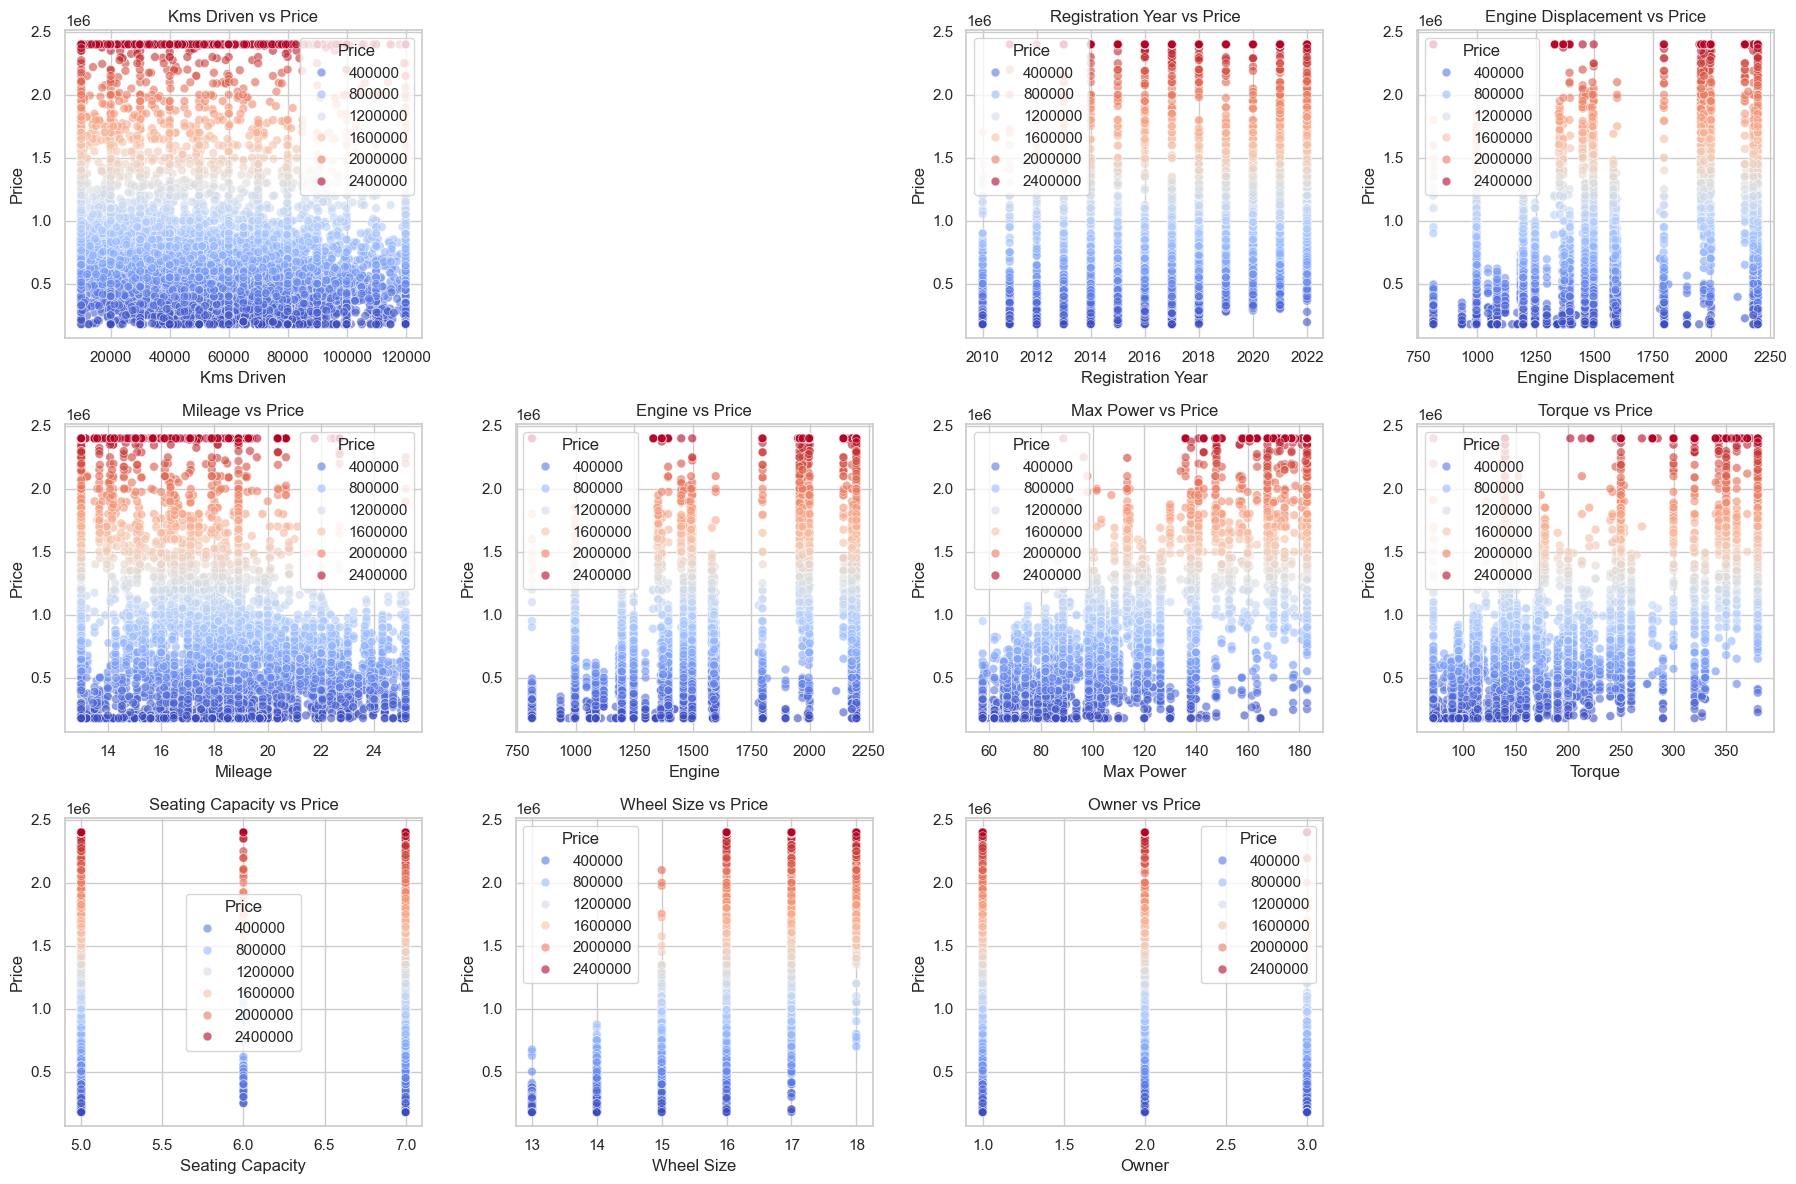

### Correlation Heatmap


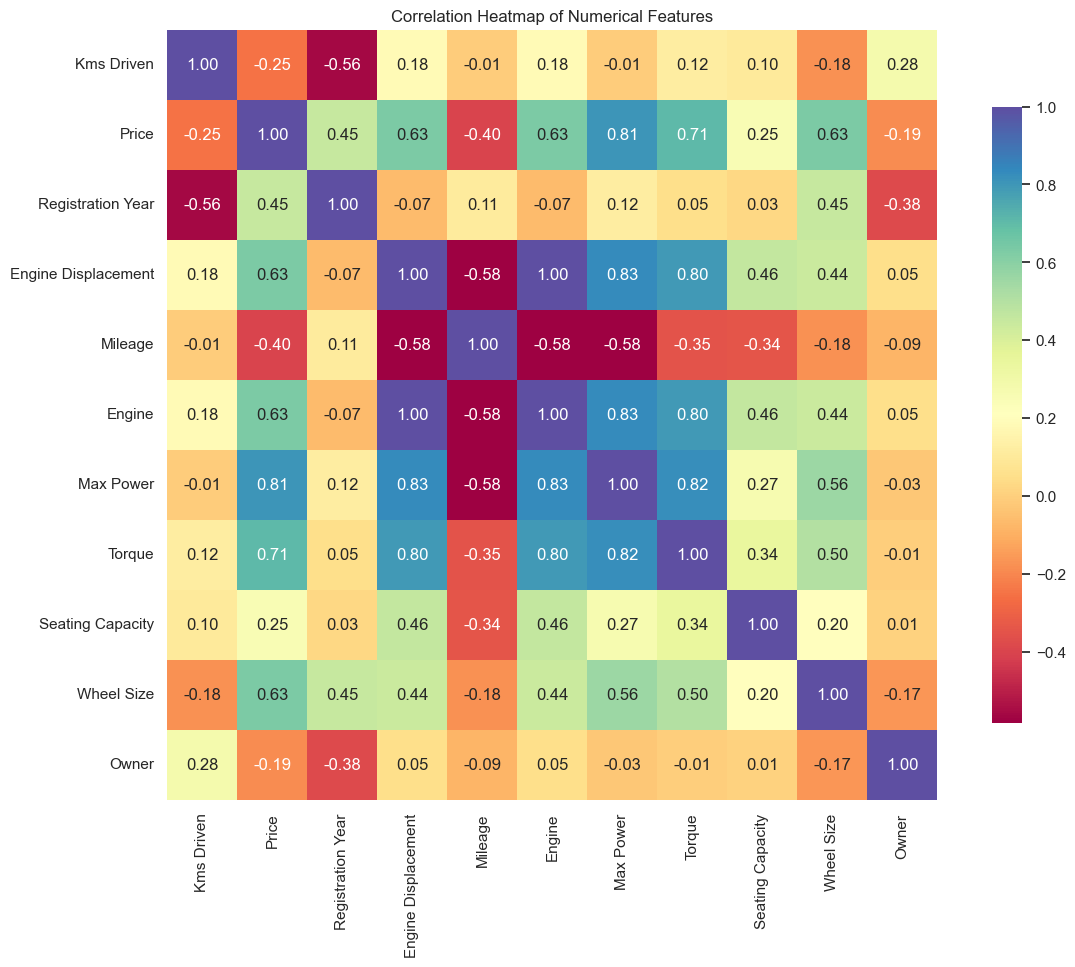

### FacetGrid Analysis for Multi-variable Comparison


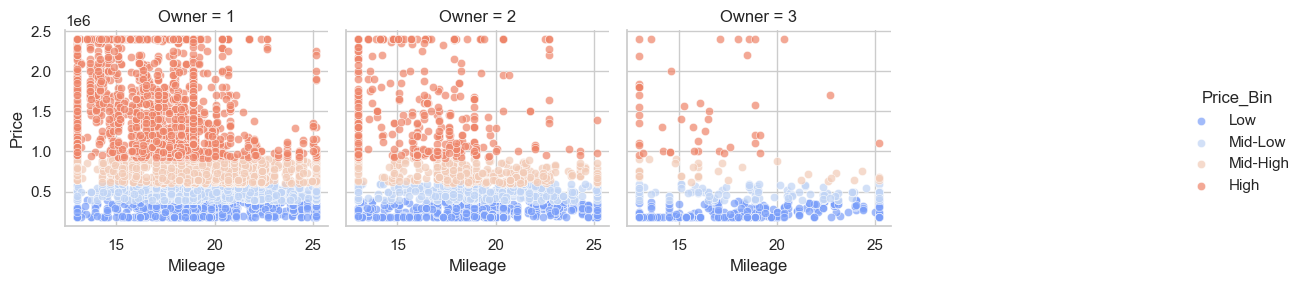

## Feature Selection
### Top 10 Important Features for Price Prediction


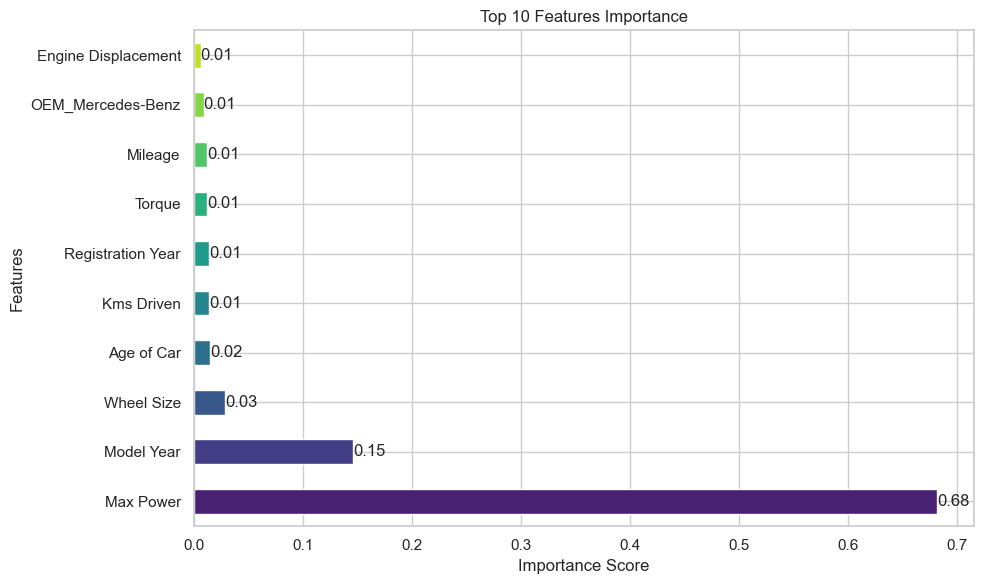

In [18]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats
from sklearn.ensemble import RandomForestRegressor

# Set Seaborn style and palette for colorful and clear visuals
sns.set(style='whitegrid', palette='Set2')

# --- a) Descriptive Statistics ---
print("## Descriptive Statistics")
# Display descriptive statistics only for numerical columns to avoid `unique`, `top`, and `freq`
numerical_summary = df_cleaned.describe()
print("Summary Statistics for numerical columns in the dataset:")
print(numerical_summary)

print("\n## Missing Values:\n")
print(df_cleaned.isnull().sum())

# Optional: Separate descriptive statistics for categorical columns if needed
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    print("Summary Statistics for categorical columns in the dataset:")
    print(df_cleaned[categorical_columns].describe())

# --- b) Data Visualization ---
print("## Data Visualizations")

# i) Histograms with KDE plots for numerical features
print("### Histograms with KDE for Numerical Features")
numerical_columns = ['Kms Driven', 'Price', 'Registration Year',
                     'Engine Displacement', 'Mileage', 'Engine',
                     'Max Power', 'Torque', 'Seating Capacity', 'Wheel Size', 'Owner']

# Apply winsorization to handle outliers
for col in numerical_columns:
    df_cleaned[col] = mstats.winsorize(df_cleaned[col], limits=[0.05, 0.05])

# Plot histograms
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 4, i + 1)
    sns.histplot(df_cleaned[col], kde=True, bins=30, color=sns.color_palette('muted')[i % 10])
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

# ii) Box plots for outlier detection
print("### Box Plots for Outlier Detection")
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=df_cleaned[col], color=sns.color_palette('pastel')[i % 10])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

# iii) Scatter plots to examine relationships with Price
print("### Scatter Plots of Features vs Price")
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_columns):
    if col != 'Price':  # Avoid self-referencing
        plt.subplot(3, 4, i + 1)
        sns.scatterplot(data=df_cleaned, x=col, y='Price', hue='Price', palette='coolwarm', alpha=0.6, edgecolor='w', s=40)
        plt.title(f'{col} vs Price')
plt.tight_layout()
plt.show()

# iv) Correlation Heatmap
print("### Correlation Heatmap")
plt.figure(figsize=(14, 10))
correlation_matrix = df_cleaned[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Spectral', square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# v) FacetGrid for multi-variable analysis (with Price Binning)
print("### FacetGrid Analysis for Multi-variable Comparison")
df_cleaned['Price_Bin'] = pd.qcut(df_cleaned['Price'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])
g = sns.FacetGrid(df_cleaned, col="Owner", hue="Price_Bin", palette="coolwarm", col_wrap=4, height=3)
g.map(sns.scatterplot, "Mileage", "Price", alpha=0.7, edgecolor='w').add_legend()
plt.show()

# --- c) Feature Selection ---
print("## Feature Selection")

# Prepare features and target variable
X = df_cleaned.drop(columns=['Price', 'Price_Bin'])
y = df_cleaned['Price']

# Fit a Random Forest Regressor to identify feature importance
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

# Feature importance visualization with annotations
print("### Top 10 Important Features for Price Prediction")
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh', figsize=(10, 6), color=sns.color_palette('viridis', 10))
plt.title('Top 10 Features Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()

# Annotate feature importance scores
for index, value in enumerate(feature_importance.nlargest(10)):
    plt.text(value, index, f"{value:.2f}", va='center')
plt.show()


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Assuming `df_cleaned` is your cleaned dataset
# 1. Separate Features and Target
X = df_cleaned.drop('Price', axis=1)  # Features
y = df_cleaned['Price']  # Target variable

# 2. Train-Test Split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# 3. Scaling: Apply scaling to all numerical features using MinMaxScaler
scaler = StandardScaler()

# 4. Define Pipelines for Models (with Scaling for Linear Regression and PCA for Linear Regression)
models = {
    'Decision Tree': Pipeline([('scaler', scaler), ('model', DecisionTreeRegressor(random_state=42))]),
    'Random Forest': Pipeline([('scaler', scaler), ('model', RandomForestRegressor(random_state=42))]),
    'Gradient Boosting': Pipeline([('scaler', scaler), ('model', GradientBoostingRegressor(random_state=42))]),
    'Lasso Regression': Pipeline([('scaler', scaler), ('model', Lasso(alpha=0.1))]),
    'Ridge Regression': Pipeline([('scaler', scaler), ('model', Ridge(alpha=0.1))]),
    'Linear Regression': Pipeline([('scaler', scaler), ('pca', PCA(n_components=0.95, random_state=42)), ('model', LinearRegression())])
}

# 5. Model Training and Cross-Validation
print("\n==== Training Model Performance (Cross-Validation Scores) ====")
for name, pipeline in models.items():
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    print(f"{name}: Mean R2 = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")

# 6. Train Final Models and Evaluate on Test Set
results = {}

# Train all models and evaluate performance on the test set
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

# 7. Output Test Set Performance
print("\n==== Test Set Performance ====")
for name, metrics in results.items():
    print(f"{name} -> MAE: {metrics['MAE']:.2f}, MSE: {metrics['MSE']:.2f}, R²: {metrics['R2']:.4f}")

# 8. Hyperparameter Tuning for Random Forest (Optional)
param_dist = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    models['Random Forest'],  # Use the Random Forest pipeline
    param_distributions=param_dist,
    n_iter=10,  # Number of combinations to try
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("\nBest Parameters from Random Search:")
print(random_search.best_params_)

# 9. Evaluate the Best Model on the Test Set

# After hyperparameter tuning
best_model = random_search.best_estimator_

# Get the name of the best model
best_model_name = type(best_model.named_steps['model']).__name__

# Make predictions with the best model
y_pred_best = best_model.predict(X_test)

# Calculate performance metrics
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Print the results including the best model name
print(f"\nBest Model: {best_model_name} -> MAE: {mae_best:.2f}, MSE: {mse_best:.2f}, R²: {r2_best:.4f}")


Training set size: (6549, 380)
Testing set size: (1638, 380)

==== Training Model Performance (Cross-Validation Scores) ====
Decision Tree: Mean R2 = 0.8739, Std = 0.0074
Random Forest: Mean R2 = 0.9251, Std = 0.0021
Gradient Boosting: Mean R2 = 0.9117, Std = 0.0039
Lasso Regression: Mean R2 = 0.8279, Std = 0.0488
Ridge Regression: Mean R2 = 0.8253, Std = 0.0491
Linear Regression: Mean R2 = 0.7853, Std = 0.0614

==== Test Set Performance ====
Decision Tree -> MAE: 130082.06, MSE: 68468827305.65, R²: 0.8907
Random Forest -> MAE: 104201.20, MSE: 41250106205.62, R²: 0.9341
Gradient Boosting -> MAE: 132578.19, MSE: 54242271714.05, R²: 0.9134
Lasso Regression -> MAE: 163012.97, MSE: 83909099783.46, R²: 0.8660
Ridge Regression -> MAE: 164795.67, MSE: 89094432552.22, R²: 0.8577
Linear Regression -> MAE: 180333.82, MSE: 100655741783.10, R²: 0.8393
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters from Random Search:
{'model__n_estimators': 100, 'model__min_samples_s

In [22]:
import joblib

# Save the best model as a .pkl file
joblib.dump(best_model, 'price_prediction_model_updated.pkl')


['price_prediction_model_updated.pkl']

In [23]:
# Save column names from X_train
joblib.dump(X_train.columns, 'feature_columns.pkl')


['feature_columns.pkl']